Sentiment Analysis For Amazon Reviews

Importing the libraries

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import re  # regular exp
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

Importing Dataset

In [47]:
dataset = pd.read_csv('1429_1.csv')


# Taking only useful data from dataset
dataset = dataset.iloc[:2,[17,16,14,11]]

data_encoded = dataset.replace({
    'reviews.doRecommend': {True: 1, False : 0}
})
data_encoded.head(5)

C:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,reviews.title,reviews.text,reviews.rating,reviews.doRecommend
0,Kindle,This product so far has not disappointed. My c...,5.0,1.0
1,very fast,great for beginner or experienced person. Boug...,5.0,1.0
2,Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...,5.0,1.0
3,Good!!!,I've had my Fire HD 8 two weeks now and I love...,4.0,1.0
4,Fantastic Tablet for kids,I bought this for my grand daughter when she c...,5.0,1.0


<AxesSubplot:>

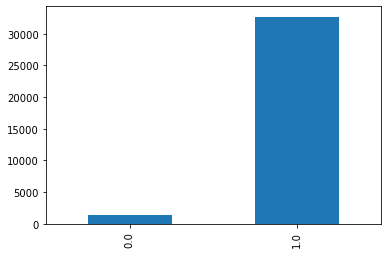

In [67]:
data_encoded['reviews.doRecommend'].value_counts().sort_index().plot.bar()

Taking Care of missing data

In [48]:
# Discarding observations having missing data

dataset = data_encoded.dropna(axis = 0,how = 'any') # drop null value rows 
X = dataset.iloc[:, :-1].values  # getting input records 

#Storing rating saperately to use it later 
rating = X[:,-1]

y = dataset.iloc[:, -1].values # getting output 

rating

array([5.0, 5.0, 5.0, ..., 5.0, 4.0, 4.0], dtype=object)

Visualizing Dataset

In [49]:
dataset.head(8)

,reviews.title,reviews.text,reviews.rating,reviews.doRecommend
0,Kindle,This product so far has not disappointed. My c...,5.0,1.0
1,very fast,great for beginner or experienced person. Boug...,5.0,1.0
2,Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...,5.0,1.0
3,Good!!!,I've had my Fire HD 8 two weeks now and I love...,4.0,1.0
4,Fantastic Tablet for kids,I bought this for my grand daughter when she c...,5.0,1.0
5,Just what we expected,This amazon fire 8 inch tablet is the perfect ...,5.0,1.0
6,great e-reader tablet,"Great for e-reading on the go, nice and light ...",4.0,1.0
7,Great for gifts,"I gave this as a Christmas gift to my inlaws, ...",5.0,1.0


In [50]:
print(X)
print(y)

[['Kindle'
  'This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.'
  5.0]
 ['very fast'
  'great for beginner or experienced person. Bought as a gift and she loves it'
  5.0]
 ['Beginner tablet for our 9 year old son.'
  'Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, learn how to Skype on it already...'
  5.0]
 ...
 ['Love it'
  'Simply the best to watch tv series and movies. It works even better if you are an Amazon Prime subscriber, with access to a many free goodies.'
  5.0]
 ['Try it, you will like it'
  'I was looking for ways to cut cost from a raising cable bill and a friend suggested I try the Amazon Fire. At first I didn���t know if this was something I could do. Once I was able to maneuver through the process, I love it.'
  4.0]
 ['Great little device'
  'I enjoy my kindle tv, it beats paying for cable every month ������'
  4.0]]
[1. 1.

Cleaning the Dataset

In [51]:

# Downloading stopwords which does not having much significance
nltk.download('stopwords')


# Stemmer will reduce words in their root form

ps = PorterStemmer()
all_stopwords = stopwords.words('english')

# Removing some stopwords which have significance effect in building this model
# excluding some words from stopwords(all_stopwords)
rem = ['not', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', 
       "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', 
       "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'don', "don't", 
       'just', 'too', 'very', 'no', 'nor', 'only', 'own', 'same', 'again', 'against', 'but',]
for s in rem:
  all_stopwords.remove(s) # exeption of the above terms from stop words 

def find_clean_text(temp):
  # Removing all characters other than alphabet
  temp = re.sub('[^a-zA-Z]', ' ', temp)
  temp = temp.lower()
  temp = temp.split()
  temp = [ps.stem(word) for word in temp if not word in set(all_stopwords)] # stemming and escluding stopwords 
  temp = ' '.join(temp)
  return temp


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [52]:
corpus = []
for i in range(X.shape[0]):
  # Concatanating both title and detailed review
  temp = X[i][0] + ' ' + X[i][1]
  temp = find_clean_text(temp)
  corpus.append(temp)


Creating the Bag of Words model

In [53]:
cv = CountVectorizer(max_features = 3000)
X = cv.fit_transform(corpus).toarray()

#Adding rating in the matrix of feature X

rating = rating.reshape(rating.shape[0],1)  # conver from horizontal to veryical
X = np.append(X,rating,axis=1) # concating the review vector with its rate 
X


array([[0, 1, 0, ..., 0, 0, 5.0],
       [0, 0, 0, ..., 0, 0, 5.0],
       [0, 0, 0, ..., 0, 0, 5.0],
       ...,
       [0, 0, 0, ..., 0, 0, 5.0],
       [0, 0, 1, ..., 0, 0, 4.0],
       [0, 0, 0, ..., 0, 0, 4.0]], dtype=object)

Splitting the dataset into the Training set and Test set

In [55]:
# Splitting dataset into test set and train set which have equal percentage of data with both positive and negative review
#This is done as precautionary measure considering that very small number (approx 1300 out of 34000) data have negative review.
pos_x = []
pos_y = []
neg_x = []
neg_y = []
for i in range(X.shape[0]):
  if y[i]==1:
    pos_x.append(X[i])
    pos_y.append(y[i])
  else:
    neg_x.append(X[i])
    neg_y.append(y[i])

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(pos_x, pos_y, test_size = 0.20, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(neg_x, neg_y, test_size = 0.20 , random_state=0)

for i in range(len(X_train1)):
  X_train.append(X_train1[i])
  y_train.append(y_train1[i])
for i in range(len(X_test1)):
  X_test.append(X_test1[i])
  y_test.append(y_test1[i])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


Training the Multinomial Naive Bayes model on the Training set

In [56]:
classifier = MultinomialNB()
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

ros = RandomOverSampler(sampling_strategy=1.0, random_state=0)

X_train_balanced, y_train_balanced = ros.fit_resample(X_train_rus, y_train_rus)

classifier.fit(X_train_balanced, y_train_balanced)

MultinomialNB()

Making the Confusion Matrix

In [57]:
print('Result on training set :')
print('Confusion matrix :')
y_pred_train=classifier.predict(X_train_balanced)
con_mat_train=confusion_matrix(y_train_balanced, y_pred_train) # confusion matrix
print(con_mat_train)
print('accuracy : ',accuracy_score(y_train_balanced,y_pred_train ))

print('Result on test set :')
y_pred_test = classifier.predict(X_test)
print('Confusion matrix :')
con_mat_test=confusion_matrix(y_test, y_pred_test)
print(con_mat_test)
print('accuracy',accuracy_score(y_test, y_pred_test))

Result on training set :
Confusion matrix :
[[1964  250]
 [ 130 2084]]
accuracy :  0.9141824751580849
Result on test set :
Confusion matrix :
[[ 240   37]
 [ 570 5966]]
accuracy 0.9109056216057537


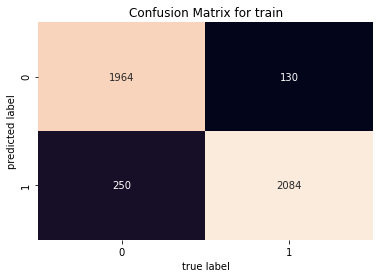

In [58]:
sns.heatmap(con_mat_train.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for train')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig("train_confusion_matrix.png")
plt.show()

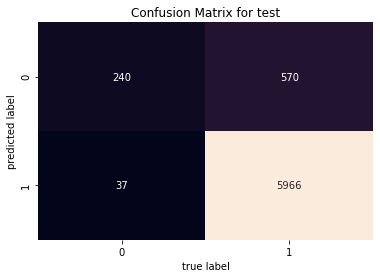

In [59]:
sns.heatmap(con_mat_test.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for test')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig("test_confusion_matrix.png")
plt.show()

Making Prediction on some reviews from test set

In [60]:
random.seed(10)


index = random.randrange(dataset.shape[0])
print('Title :',dataset['reviews.title'][index],'\nReview :',dataset['reviews.text'][index],'\nRating :',dataset['reviews.rating'][index])
print("True value :", dataset['reviews.doRecommend'][index])

clean_seq=find_clean_text(dataset['reviews.title'][index]+' '+dataset['reviews.text'][index])
cv_mat=cv.transform ([clean_seq])
seq=np.append (cv_mat.toarray(),[[dataset['reviews.rating'][index]]],axis=1)

prediction=classifier.predict(seq)

print("Prediction :",int(prediction))

Title : Awesome Tablet 
Review : This tablet was a Christmas gift for my dad. It has great resolution and is easy to use. With Amazon prime you get free movies, books, and games. I would highly recommend. 
Rating : 5.0
True value : 1.0
Prediction : 1


In [61]:

index = random.randrange(dataset.shape[0])

print('Title :',dataset['reviews.title'][index],'\nReview :',dataset['reviews.text'][index],'\nRating :',dataset['reviews.rating'][index])
print("True value :", dataset['reviews.doRecommend'][index])

clean_seq=find_clean_text(dataset['reviews.title'][index]+' '+dataset['reviews.text'][index])
cv_mat=cv.transform ([clean_seq])
seq=np.append (cv_mat.toarray(),[[dataset['reviews.rating'][index]]],axis=1)

prediction=classifier.predict(seq)

print("Prediction :",int(prediction))

Title : Good home automation product 
Review : Integrated easily with ecobee3, insteon products. Music playing capability is great with prime membership 
Rating : 5.0
True value : 1.0
Prediction : 1


In [62]:
index = random.randrange(dataset.shape[0])

print('Title :',dataset['reviews.title'][index],'\nReview :',dataset['reviews.text'][index],'\nRating :',dataset['reviews.rating'][index])
print("True value :", dataset['reviews.doRecommend'][index])

clean_seq=find_clean_text(dataset['reviews.title'][index]+' '+dataset['reviews.text'][index])
cv_mat=cv.transform ([clean_seq])
seq=np.append (cv_mat.toarray(),[[dataset['reviews.rating'][index]]],axis=1)

prediction=classifier.predict(seq)

print("Prediction :",int(prediction))

Title : I like it 
Review : I bought one from BestBuy instead of buying one that is jail-broke. That is a moral choice for me. That being said, I can add the apps I want. The hardest part so far is getting used to not having a DVR and not being able to fast fwd through commercials...but I'm saving over $100/ month over cable, including the $40/month of apps that I'm currently buying. 
Rating : 4.0
True value : 1.0
Prediction : 0


In [63]:

index = 126

print('Title :',dataset['reviews.title'][index],'\nReview :',dataset['reviews.text'][index],'\nRating :',dataset['reviews.rating'][index])
print("True value :", dataset['reviews.doRecommend'][index])

clean_seq=find_clean_text(dataset['reviews.title'][index]+' '+dataset['reviews.text'][index])
cv_mat=cv.transform ([clean_seq])
seq=np.append (cv_mat.toarray(),[[dataset['reviews.rating'][index]]],axis=1)

prediction=classifier.predict(seq)

print("Prediction :",int(prediction))

Title : TERRIBLE DONT BUY 
Review : i Bought this around black friday for $60 hoping it would be awesome... it failed so hard i tried multiple different micro SD cards none of which were recognized and YES i formated them with every format i could think of ... Fat32, NTFS, Fat, Xfat... i even tried to have the tablet do it... didnt work... to make matters worse half the apps i wanted to use werent in the app store and i came to find out that it isnt linked to the normal google play store this tablet has its own app store which is missing many common apps... the main reason i bought this was to play clash of clans and i cant because it wasnt on the app store... i tried to also use aftermarket play stores to play COC but it didnt work... launched and played 1 time but didnt work or update after that... needless to say i returned it and bought a $250 samsung galaxy tab A 10.1 (2016 version) with S-pen and its WAYYYYY better... bottom line you get what you pay for... also hint the s-pen ve

In [64]:
index = 169

print('Title :',dataset['reviews.title'][index],'\nReview :',dataset['reviews.text'][index],'\nRating :',dataset['reviews.rating'][index])
print("True value :", dataset['reviews.doRecommend'][index])

clean_seq=find_clean_text(dataset['reviews.title'][index]+' '+dataset['reviews.text'][index])
cv_mat=cv.transform ([clean_seq])
seq=np.append (cv_mat.toarray(),[[dataset['reviews.rating'][index]]],axis=1)

prediction=classifier.predict(seq)

print("Prediction :",int(prediction))


Title : Ended up returning 
Review : I bought this tablet for my 4 year old daughter. Too many advertisements. I would rather pay more and not have a single ad. 
Rating : 1.0
True value : 0.0
Prediction : 0


In [70]:
title=input("enter title : ")
review=input("enter review : ")
rate=float(input("enetr rate : "))



clean_seq=find_clean_text(title+' '+review)
cv_mat=cv.transform ([clean_seq])
seq=np.append (cv_mat.toarray(),[[rate]],axis=1)

prediction=classifier.predict(seq)

print("Prediction :",int(prediction))

enter title : ahmed 
enter review : this book is very good
enetr rate : 2
Prediction : 1
